In [30]:
# 1. SETUP: IMPORTS AND Plots


# Core imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Plots
sns.set_theme(style="darkgrid", palette="rocket")
plt.rcParams["figure.figsize"] = (18, 8)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14

print("Setup complete")


Setup complete


In [31]:
# 2. DATA LOADING
#######################

import os
import pandas as pd

# Discover and categorize all CSV files within the "data" subdirectories
# This code will search recursively through all folders inside the "data" directory.
#Used LLM to find the os.walk functions & libs so it works after git clone

csgo_files = []
tf2_files = []
dota2_files = []

# Define the top-level directory to start the search from.
search_directory = "data"

# First, check if the "data" directory exists to provide a clear error if it doesn"t.
if not os.path.isdir(search_directory):
    print(f"ERROR: The search directory '{search_directory}' was not found.")
    print("Please make sure you have a folder named 'data' in the same location as your notebook.")
else:
    # os.walk() explores a directory and all of its subdirectories.
    # "root" is the path to the current folder being scanned.
    # "files" is a list of filenames in that "root" folder.
    
    for root, dirs, files in os.walk(search_directory):
        for filename in files:
            # Check if the file matches our criteria (e.g., ends with "_history.csv").
            if filename.endswith("_history.csv"): 
                # IMPORTANT: Construct the full, correct path to the file.
                full_path = os.path.join(root, filename)
                
                # Categorize the file based on its name and append the full path.
                if filename.startswith("CS_"):
                    csgo_files.append(full_path)
                elif filename.startswith("TF2_"):
                    tf2_files.append(full_path)
                elif filename.startswith("Dota_"):
                    dota2_files.append(full_path)

# Print the results of the file discovery.
print(f"Found files:\n {len(csgo_files)} items for CS:GO,\n {len(tf2_files)} items for TF2,\n {len(dota2_files)} items for Dota 2")


# --- Function to load and standardize item data
def load_and_prepare_item_data(filepath, game_name):
    """
    Loads an items price history, standardizes column names, and formats the data.
    """
    try:
        df = pd.read_csv(filepath)
        df = df.rename(columns={"timestamp": "date"})
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
        if "price_mean" in df.columns:
            df = df.rename(columns={"price_mean": "price"})
        if "volume_sum" in df.columns:
            df = df.rename(columns={"volume_sum": "volume"})
        df["game"] = game_name
        return df[["game", "price", "volume"]]
    except Exception as e:
        print(f"Error loading or processing {filepath}: {e}")
        return None


# Load all discovered files into a single dictionary
all_item_data = {}
file_lists = {"CS:GO": csgo_files, "TF2": tf2_files, "Dota 2": dota2_files}

for game, files in file_lists.items():
    # "file" now correctly holds the full path (e.g., "data/folder/CS_file.csv")
    for file in files:
        # We use os.path.basename() to get just the filename for the dictionary key.
        item_name = os.path.basename(file)
        item_df = load_and_prepare_item_data(file, game)
        if item_df is not None:
            all_item_data[item_name] = item_df
        
print(f"\nFinished loading data successfully for {len(all_item_data)} items.")

Found files:
 116 items for CS:GO,
 14 items for TF2,
 12 items for Dota 2

Finished loading data successfully for 142 items.


In [32]:
# 3. DATA AGGREGATION AND NORMALIZATION
# ==============================================================================

#Lists for Group
csgo_series = []
tf2_series = []
dota2_series = []


# Aggregating and normalizing price data for market comparison
# Used LLM for simplifying normalization and compacting of code

print("\n Aggregating and normalizing price data for market comparison...")

for item_name, df in all_item_data.items():
    if df is not None and not df.empty:
        df_period = df.loc["2022-01-01":"2024-12-31"] 
        if not df_period.empty:
            normalized_price = (df_period["price"] / df_period["price"].iloc[0]) * 100
            game_name = df["game"].iloc[0]
            if game_name == "CS:GO":
                csgo_series.append(normalized_price)
            elif game_name == "TF2":
                tf2_series.append(normalized_price)
            elif game_name == "Dota 2":
                dota2_series.append(normalized_price)


##############################
# Calculate the Average Daily Market Trend for Each Game, if Data Exists

#     1. `pd.concat(..., axis=1)`: Combines the list of individual item price Series
#        into a single DataFrame, where each item is its own column.

#     2. `.mean(axis=1)`: Calculates the mean horizontally across all columns for each
#        day (row), giving us a single average trend line for the entire market.


if csgo_series: csgo_avg_trend = pd.concat(csgo_series, axis=1).mean(axis=1)
if tf2_series: tf2_avg_trend = pd.concat(tf2_series, axis=1).mean(axis=1)
if dota2_series: dota2_avg_trend = pd.concat(dota2_series, axis=1).mean(axis=1)




 Aggregating and normalizing price data for market comparison...


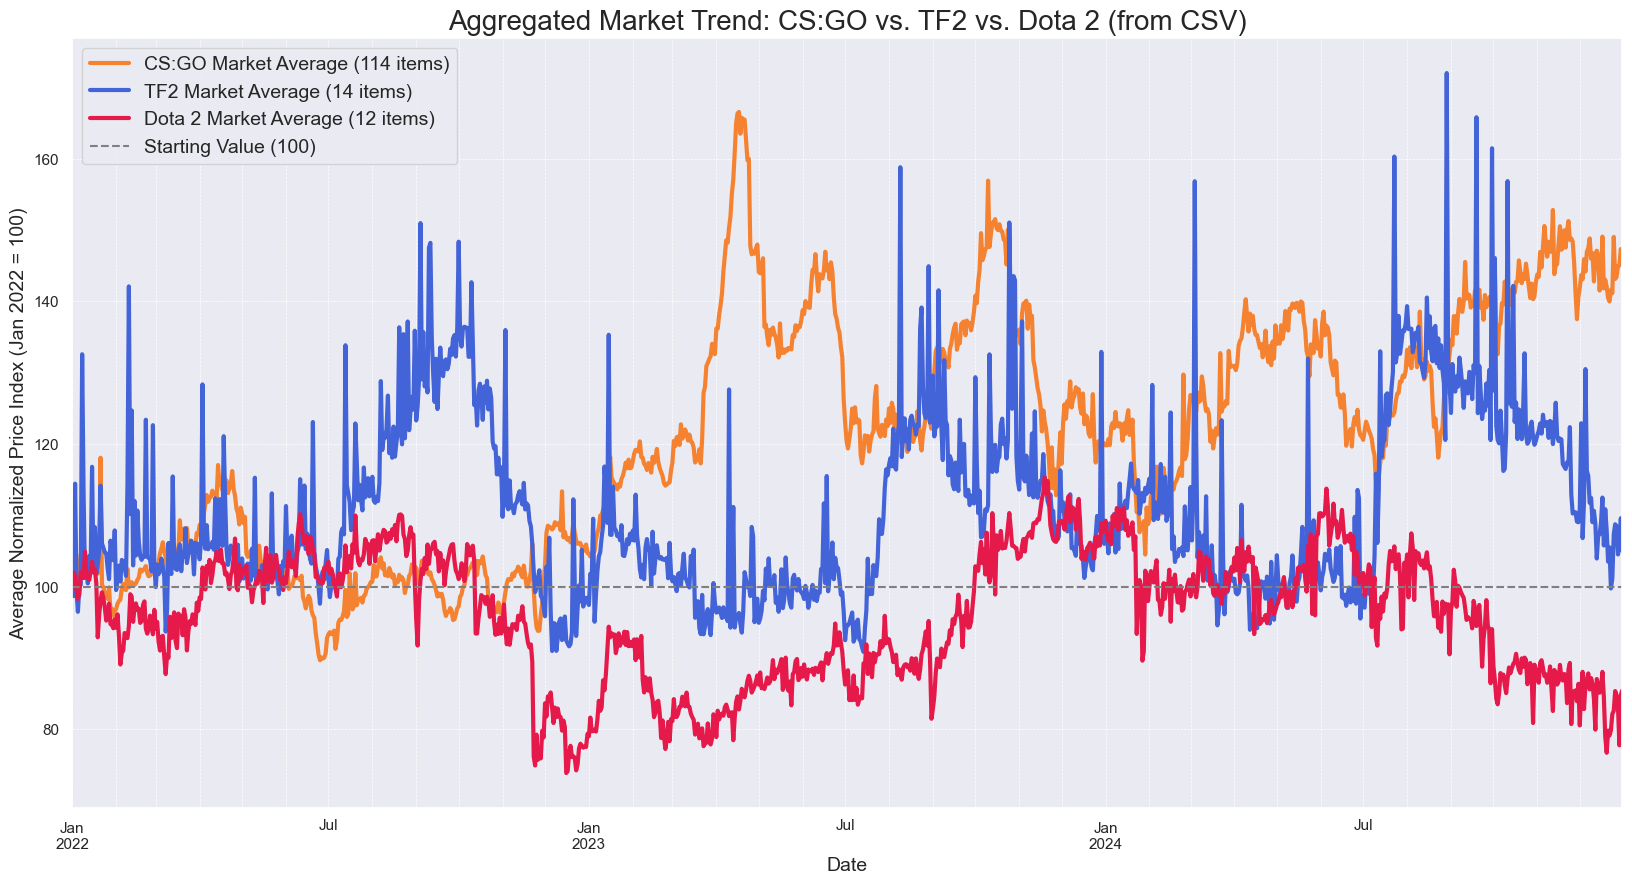

In [33]:
# 4. VISUALIZATION

# Plot 1: Basic Aggregated Market Trends
# This first plot provides a non-smoothed overview of the market trends,
# It"s useful for seeing the general direction & movement of the data over time.


# Create the figure and axes for the plot
plt.figure(figsize=(20, 10))


#   Plot Each Game"s Trend Line
# for games that had corresponding files loaded earlier in the script.


if "csgo_avg_trend" in locals():
    csgo_avg_trend.plot(label=f"CS:GO Market Average ({len(csgo_series)} items)", color="#F58231", linewidth=3)


if "tf2_avg_trend" in locals():
    tf2_avg_trend.plot(label=f"TF2 Market Average ({len(tf2_series)} items)", color="#4363D8", linewidth=3)


if "dota2_avg_trend" in locals():
    dota2_avg_trend.plot(label=f"Dota 2 Market Average ({len(dota2_series)} items)", color="#E6194B", linewidth=3)


#   Add Context and Polish the Plot  
# Add a horizontal dashed line at 100. Since all prices were normalized to start
# at 100, this line represents the initial value baseline for comparison.

plt.axhline(100, color="grey", linestyle="--", label="Starting Value (100)")

# sets clear labels for the axes and title
plt.title("Aggregated Market Trend: CS:GO vs. TF2 vs. Dota 2 (from CSV)", fontsize=20)
plt.ylabel("Average Normalized Price Index (Jan 2022 = 100)")
plt.xlabel("Date")

# displays the legend and a grid for better readability
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


# renders the final plot
plt.show()



Advanced plot saved as 'Aggregated_30DAYS_Market_Trends.png'.


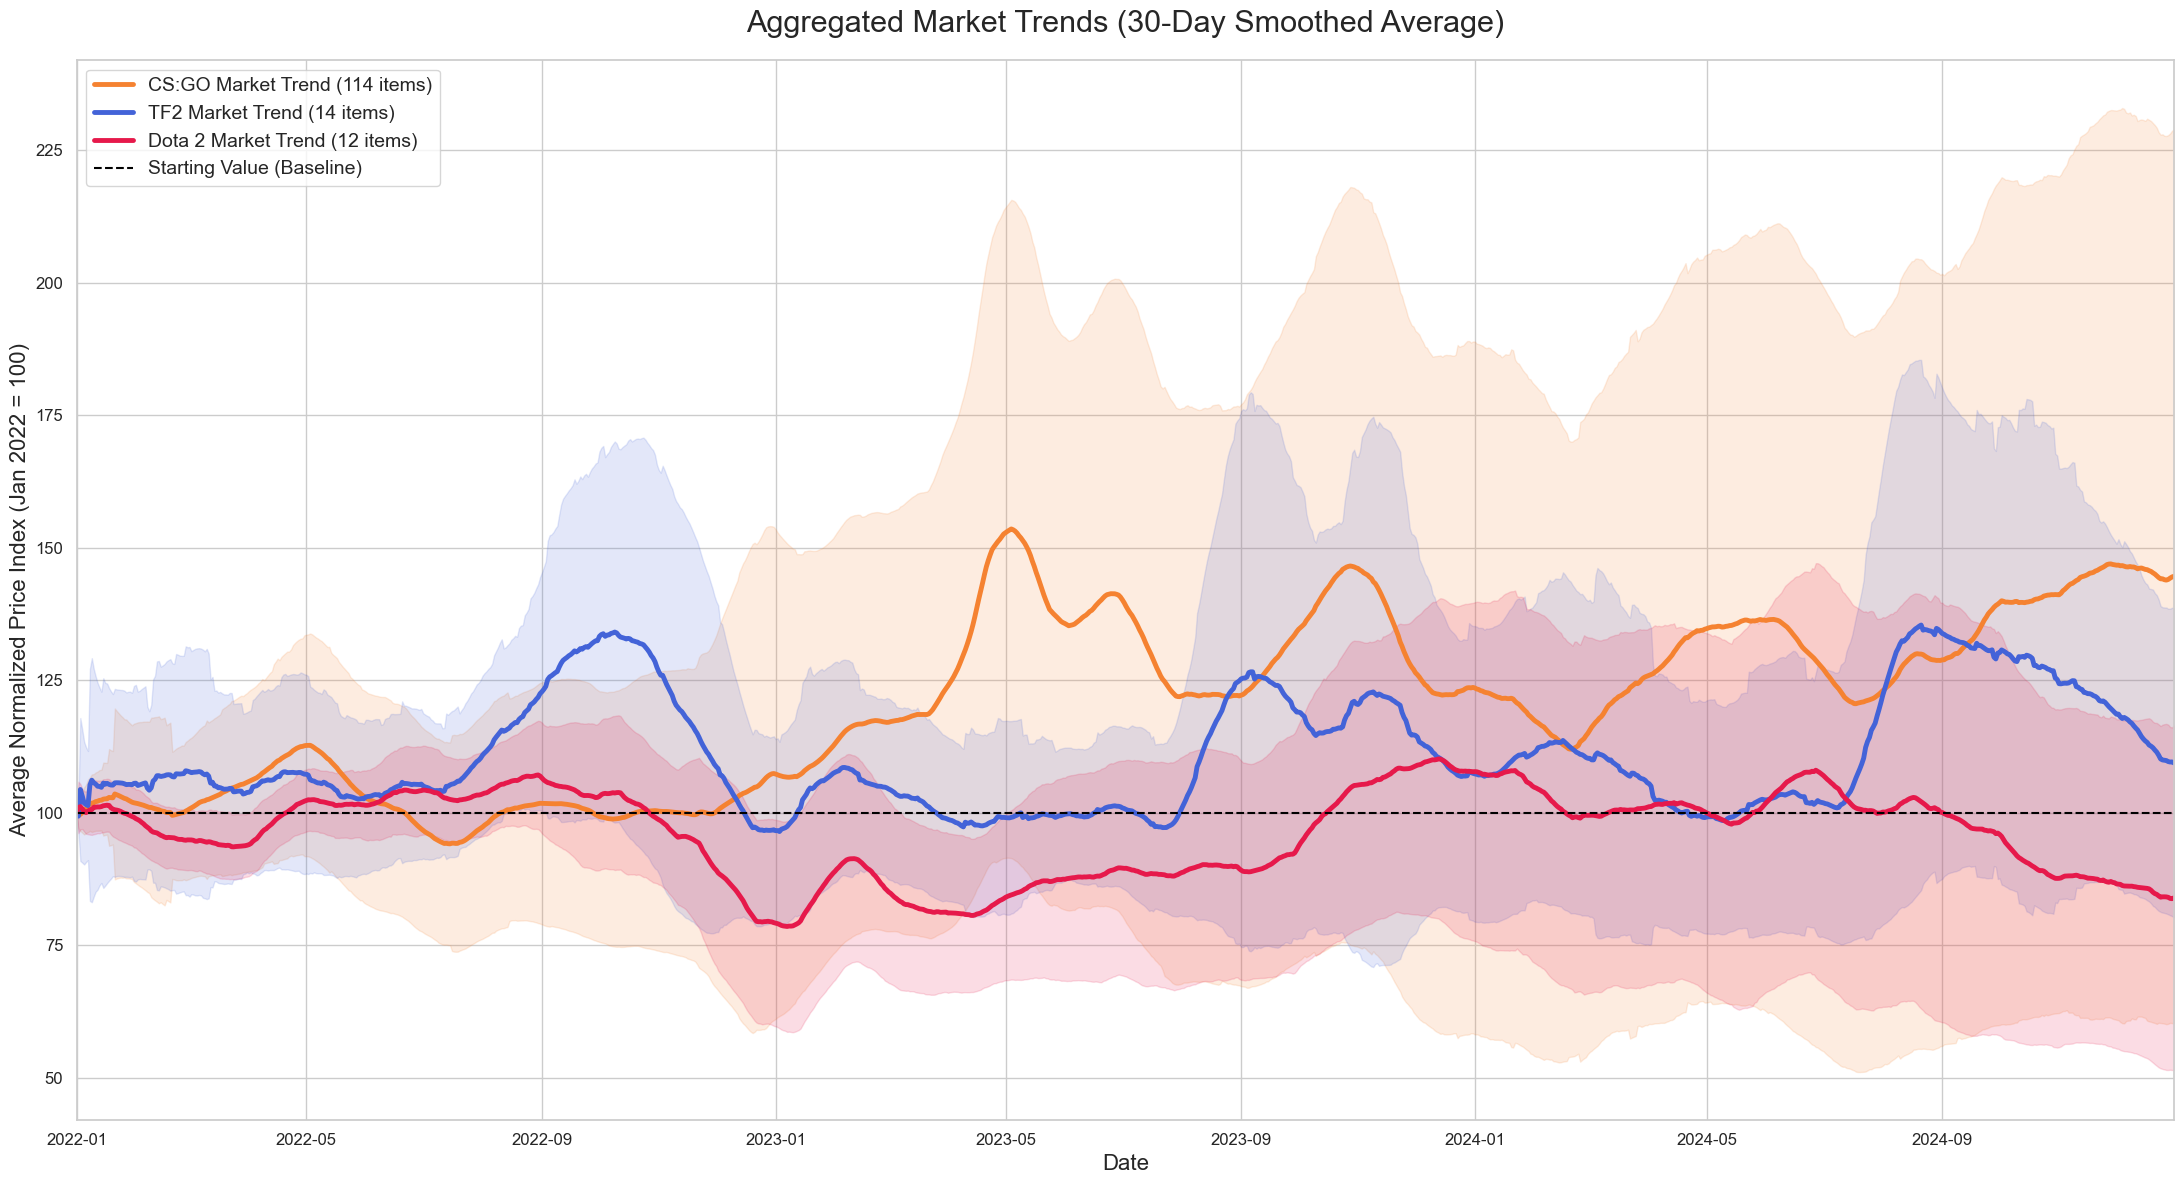

Advanced plot saved as 'Aggregated_7DAYS_Market_Trends.png'.


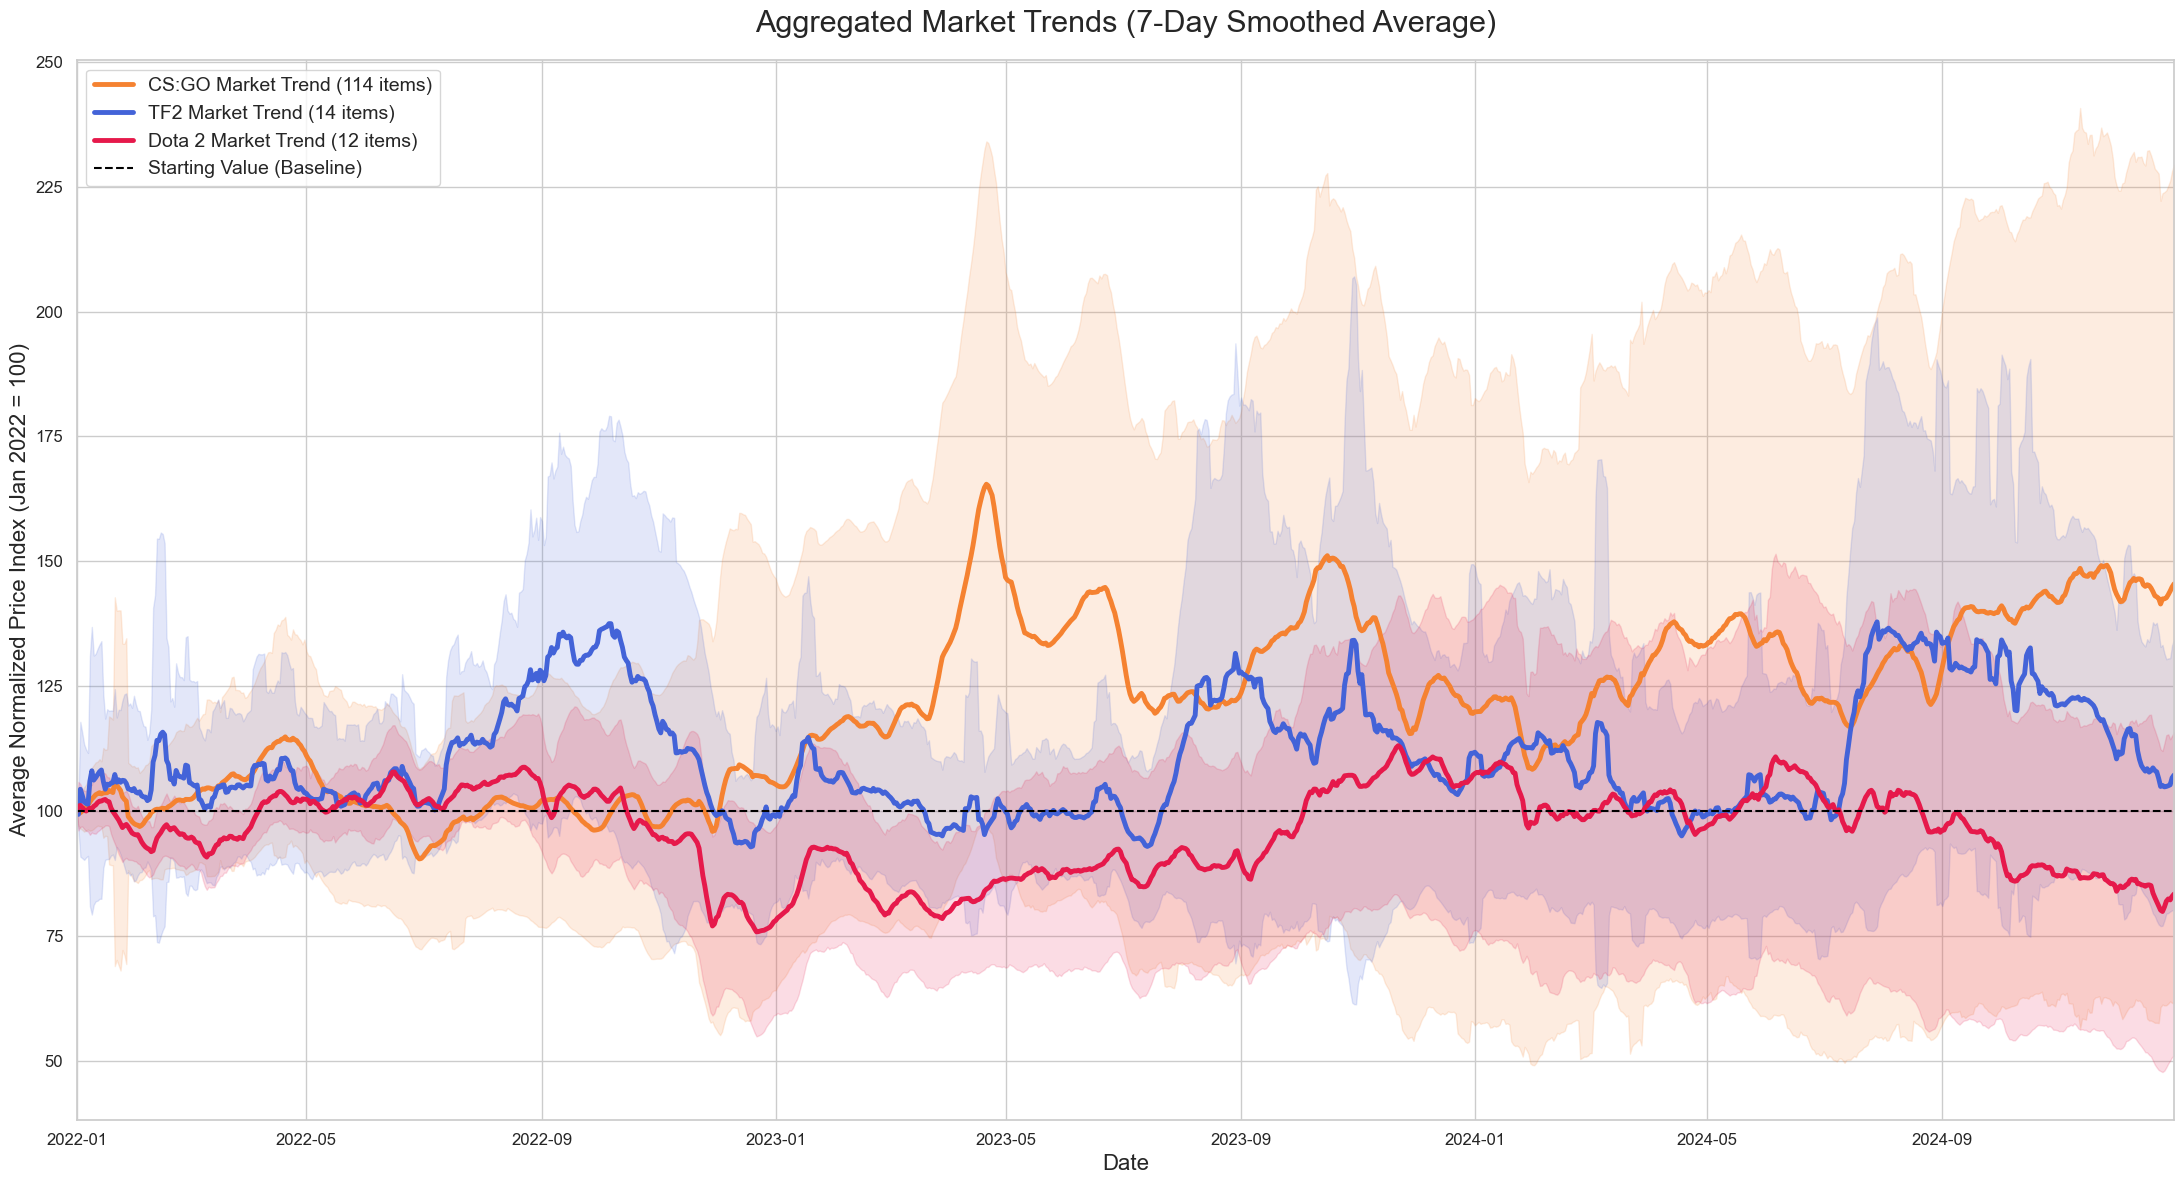

In [34]:

# Plot 2 & 3 Aggregated Market Trends, smoothed over time with noise shade for visualizing SD 
# This function was created to avoid repeating the complex plotting code for both the
# 7-day and 30-day smoothed visualizations. It takes the data and a "window_size"
# as input and handles all the logic for generating a polished, annotated plot.
# used LLM for Smoothing and Creating the Shade background with the Standard Deviation

def plot_smoothed_market_trends(cs_series, tf2_series, dota2_series, window_size):
    """
    Creates an advanced plot with smoothed trends and confidence bands.
    
    Args:
        cs_series (list): List of CS:GO normalized price Series.
        tf2_series (list): List of TF2 normalized price Series.
        dota2_series (list): List of Dota 2 normalized price Series.
        window_size (int): The rolling window size for smoothing (e.g., 7 or 30).
    """
    
    # Set a clean plot style 
    # and define consistent colors for each game.
    
    sns.set_style("whitegrid")
    market_colors = {"CS:GO": "#F58231", "TF2": "#4363D8", "Dota 2": "#E6194B"}

    
#    subplots for more control
#    figure = fig
#    axes = ax
    
    fig, ax = plt.subplots(figsize=(22, 12))

    
    
    # loops through each games data and calculates + plots its trend
    
    plot_data = {"CS:GO": cs_series, "TF2": tf2_series, "Dota 2": dota2_series}
    for game, series_list in plot_data.items():
        if series_list:
            
            #   Calculate Smoothed Trend and Confidence Interval  
            # 1. Recalculate the average trend for the current game.
    
            avg_trend = pd.concat(series_list, axis=1).mean(axis=1)

            
            # 2. Smooth the trend line using a rolling average. This reduces daily noise
            #    and makes the underlying trend clearer.
            
            smoothed_trend = avg_trend.rolling(window=window_size, min_periods=1).mean()

            
            # 3. Calculate the rolling standard deviation. This measures the price
            #    variation (uncertainty) across items on any given day.
            
            std_dev = pd.concat(series_list, axis=1).std(axis=1).rolling(window=window_size, min_periods=1).mean()


            
#  Plot the Data 
            
            # Plot the main smoothed trend line
            
            ax.plot(smoothed_trend.index, smoothed_trend.values, 
                    label=f"{game} Market Trend ({len(series_list)} items)", 
                    color=market_colors[game], linewidth=3.5)

            
            # Add a shaded area (confidence band) representing one standard deviation above and below the mean.
            # This helps visualize the markets volatile movements.
            
            ax.fill_between(smoothed_trend.index, smoothed_trend - std_dev, smoothed_trend + std_dev, 
                            color=market_colors[game], alpha=0.15, label="_nolegend_")

    
    #   Finalize and Polish the Plot  
    # Determine the date range of the data to set clear x-axis limits
    
    plot_start_date = pd.concat(cs_series, axis=1).index.min()
    plot_end_date = pd.concat(cs_series, axis=1).index.max()


    
    # Add the baseline, titles, and labels. The title is dynamic based on the window_size
    
    ax.axhline(100, color="black", linestyle="--", linewidth=1.5, label="Starting Value (Baseline)")
    ax.set_title(f"Aggregated Market Trends ({window_size}-Day Smoothed Average)", fontsize=22, pad=20)
    ax.set_ylabel("Average Normalized Price Index (Jan 2022 = 100)", fontsize=16)
    ax.set_xlabel("Date", fontsize=16)


    
    # Configure the legend, axis limits, and tick label sizes for readability
    
    ax.legend(fontsize=14, loc="upper left")
    ax.set_xlim([plot_start_date, plot_end_date])
    ax.tick_params(axis="both", which="major", labelsize=12)


    
    # Adjust plot layout to prevent labels from overlapping
    
    plt.tight_layout()


    
    # Save the generated plots to a file
    
    save_filename = f"Aggregated_{window_size}DAYS_Market_Trends.png"
    plt.savefig(save_filename, dpi=300, bbox_inches="tight")
    print(f"Advanced plot saved as '{save_filename}'.")

    
    # Display the plot.
    plt.show()




#   Generate and Display the Advanced Plots  
# generates visualizations for both

if "csgo_avg_trend" in locals():
    
    # 30-day smoothing window 
    plot_smoothed_market_trends(csgo_series, tf2_series, dota2_series, window_size=30)

    
    # 7-day smoothing window
    plot_smoothed_market_trends(csgo_series, tf2_series, dota2_series, window_size=7)

    
else:
    # if data loading failed.
    print("Average trend data not found. Skipping advanced visualizations.")